In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import h5py
import numpy as np
from scipy import optimize

import py21cmfast as p21c

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
from scripts.step_size import *
from analysis.limits import get_limits

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache


In [ ]:
! ls /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs

In [3]:
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"

bkg_fn = f"{outputs_dir}/bkg/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
fid_fn = f"{outputs_dir}/pbh-acc-PRc23-test/log10m2.000/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"

In [4]:
with h5py.File(bkg_fn, 'r') as hf:
    lcfield_bkg = hf['lightcones']['brightness_temp'][()]
lc_bkg = p21c.LightCone.read(bkg_fn)
z_s = lc_bkg.lightcone_redshifts

with h5py.File(fid_fn, 'r') as hf:
    lcfield_fid = hf['lightcones']['brightness_temp'][()]

lcfield_zm_s = [None]
for i_zm in [1, 2, 3, 4]:
    zm_fn = f"{outputs_dir}/pbh-acc-zm/pbh-acc-zm{i_zm}/log10m2.000/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"
    with h5py.File(zm_fn, 'r') as hf:
        lcfield_zm_s.append(hf['lightcones']['brightness_temp'][()])

step_size  f = 1.778e-04
limit_size f = 1.258e-02
limit_size / step_size = 70.755


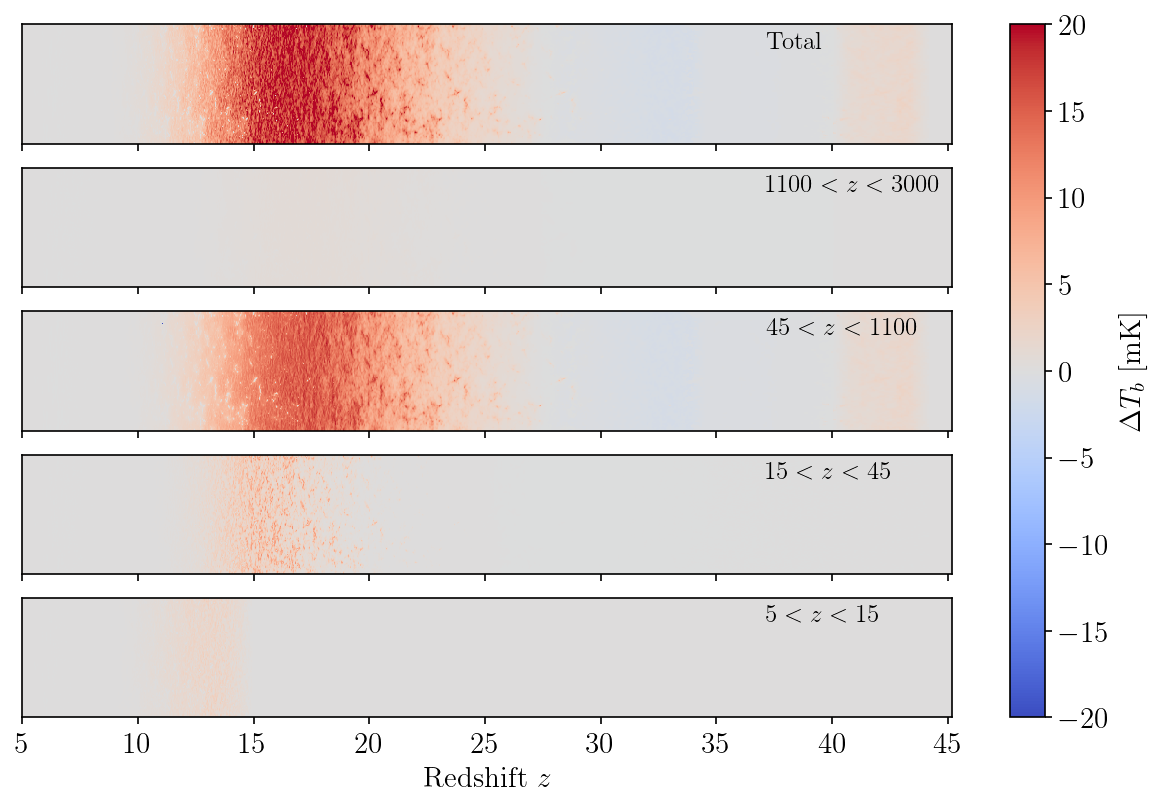

In [5]:
fb = lcfield_bkg[:, 0, :]
ff = lcfield_fid[:, 0, :]

m = 1e2 # [Msun] for pbh-acc
step_size = pbh_acc_f(m, 'PRc23')
limit_size = get_limits(m, 'pbh-acc-PRc23-test')
print(f"step_size  f = {step_size:.3e}")
print(f"limit_size f = {limit_size:.3e}")
mult = limit_size / step_size
print(f"limit_size / step_size = {mult:.3f}")

zm_text_s = [
    None,
    r'$1100 < z < 3000$',
    r'$45 < z < 1100$',
    r'$15 < z < 45$',
    r'$5 < z < 15$',
]

fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)

ax = axs[0]
im = ax.pcolormesh(z_s, np.linspace(0, 256, 128), (ff-fb) * mult, cmap='coolwarm', vmax=20, vmin=-20)
ax.set(yticks=[])
ax.text(0.8, 0.8, 'Total', transform=ax.transAxes)

for i_ax, ax in enumerate(axs[1:]):
    i_zm = i_ax + 1
    ax.pcolormesh(z_s, np.linspace(0, 256, 128), (lcfield_zm_s[i_zm][:, 0, :] - fb) * mult, cmap='coolwarm', vmax=20, vmin=-20)
    ax.set(yticks=[])
    ax.text(0.8, 0.8, zm_text_s[i_zm], transform=ax.transAxes)

axs[-1].set(xlabel=r'Redshift $z$')
cbar = fig.colorbar(im, ax=axs)
cbar.set_label(r'$\Delta T_b$ [mK]')

In [7]:
# find factor
fid_diff = lcfield_fid - lcfield_bkg

zm_factors = [None]
for i_zm in [1, 2, 3, 4]:
    zm_diff = lcfield_zm_s[i_zm] - lcfield_bkg
    def objective(multiplier):
        return np.sum((fid_diff * multiplier - zm_diff)**2)
    res = optimize.minimize_scalar(objective, bounds=(-1, 1), method='bounded')
    zm_factors.append(res.x)
    print(f"zm{i_zm} factor = {res.x:.6f}")

zm1 factor = 0.040560
zm2 factor = 0.773602
zm3 factor = 0.157880
zm4 factor = 0.041391


Text(0.5, 0.98, '$\\Delta T_b - m\\cdot\\Delta T_{b,\\mathrm{full}}$ residuals')

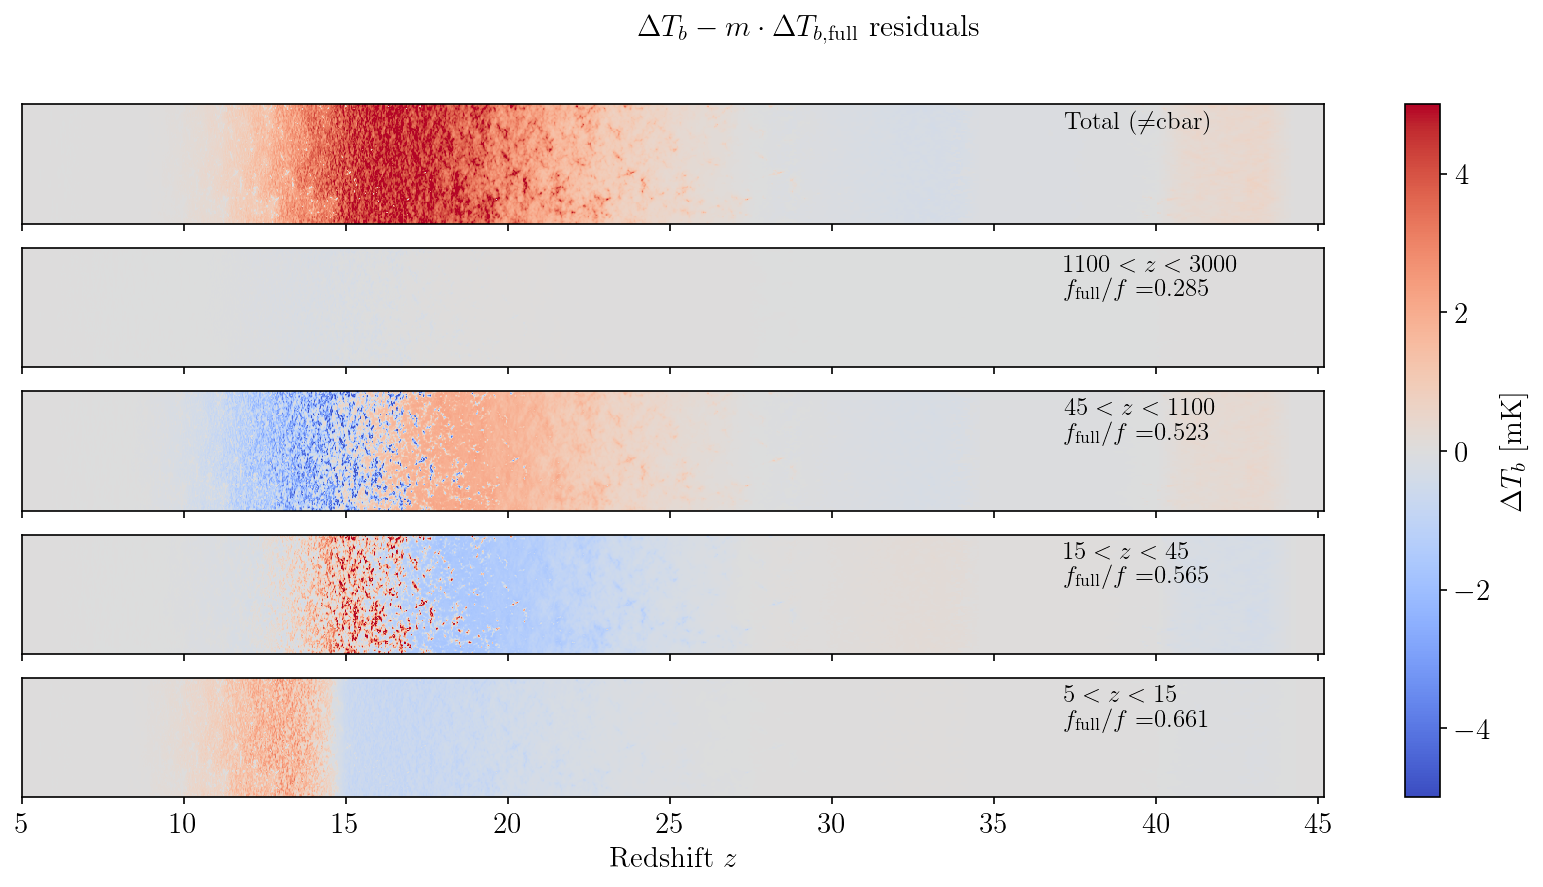

In [8]:
# residuals
zm_sigmas = [43.0159510, 150.77810039, 82.28144809, 76.17700184, 65.10182056]

fig, axs = plt.subplots(5, 1, figsize=(14, 6), sharex=True)

ax = axs[0]
im = ax.pcolormesh(z_s, np.linspace(0, 256, 128), fid_diff[:, 0, :] * mult, cmap='coolwarm', vmax=20, vmin=-20)
ax.set(yticks=[])
ax.text(0.8, 0.8, r'Total ($\neq$cbar)', transform=ax.transAxes)

for i_ax, ax in enumerate(axs[1:]):
    i_zm = i_ax + 1
    zm_diff = lcfield_zm_s[i_zm] - lcfield_bkg
    im = ax.pcolormesh(z_s, np.linspace(0, 256, 128), (zm_diff[:, 0, :] - fid_diff[:, 0, :]*zm_factors[i_zm]) * mult, cmap='coolwarm', vmax=5, vmin=-5)
    ax.set(yticks=[])
    ax.text(0.8, 0.8, zm_text_s[i_zm], transform=ax.transAxes)
    ax.text(0.8, 0.6, r'$f_\mathrm{full}/f=$' + f'{zm_sigmas[0] / zm_sigmas[i_zm]:.3f}', transform=ax.transAxes)

axs[-1].set(xlabel=r'Redshift $z$')
cbar = fig.colorbar(im, ax=axs)
cbar.set_label(r'$\Delta T_b$ [mK]')
fig.suptitle(r'$\Delta T_b - m\cdot\Delta T_{b,\mathrm{full}}$ residuals')